# Notebook to correct quenching from a glider dataset

The idea is to leverage the number of observation in a glider dataset to achieve a quenching correction using the night time profile as our training dataset of "unquenched profiles".

1) Binary classification of quenched profiles. The mid-day profiles will be labelled as quenched and mid-night profiles will be labeled as unquenched to predict if dusk and dawn profiles are quenched. 
2) Second binary classification to predict the quenched layer depth based on F/bbp values. 
3) Predict a F/bbp factor based on bbp, T, S, depth, Doy. Training is realised on the "unquenched database" and new prediction is made on quenched layers. 
4) Apply the ratio predicted before on the quench layer

## 1. Building the dataset 

Open the gliders dataset. I want to end up with one tidy table composed of profile id, doy, time, depth, T, S, F, bbp.
I will further derive a "day_period" variable that will correspond to mid-day, dusk, mid-night or dawn. TBD what time lag should be before/after sunset and sunset to consider mid-day or mid-night.

In [1]:
import xarray as xr
import polars as pl
import glob

# Get list of NetCDF files
nc_files = glob.glob("C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/nc_profiled/*.nc")

# Read and concatenate datasets
for file in nc_files:
    ds = xr.open_dataset(file, decode_times=True)
    glider_name = ds.attrs.get("trajectory").split("_")[0]
    # Select variables of interest
    vars_of_interest = ["TIME", "DEPTH", "TEMP", "CHLA", "BBP700", "ABS_SALINITY", "PROFILE_NUMBER", "LATITUDE", "LONGITUDE"]
    ds_sel = ds[vars_of_interest]
    # Convert to pandas DataFrame, then to polars DataFrame
    df_pd = ds_sel.to_dataframe().reset_index()
    df_pl = pl.from_pandas(df_pd)

    #Use only profiling data (-1 is surfacing behavior)
    df_pl = df_pl.filter(pl.col("PROFILE_NUMBER") > 0)

    df_pl = df_pl.with_columns((pl.col("PROFILE_NUMBER").cast(pl.String) + "_" + glider_name).alias("profile_id"))
    print(f"{file} processed, shape: {df_pl.shape}")

    # Concatenate DataFrames
    if 'df_concat' in locals():
        df_concat = pl.concat([df_concat, df_pl])
    else:
        df_concat = df_pl

df_concat

C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/nc_profiled\Cabot_645_Profiled.nc processed, shape: (1438541, 11)
C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/nc_profiled\Churchill_647_Profiled.nc processed, shape: (1142019, 11)
C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/nc_profiled\Doombar_648_Profiled.nc processed, shape: (1952630, 11)
C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/nc_profiled\Nelson_646_Profiled.nc processed, shape: (1951435, 11)


N_MEASUREMENTS,TIME,DEPTH,TEMP,CHLA,BBP700,ABS_SALINITY,PROFILE_NUMBER,LATITUDE,LONGITUDE,profile_id
i64,datetime[ns],f64,f32,f32,f32,f64,f64,f32,f32,str
322,2024-05-28 12:58:56.229522944,null,null,null,null,null,1.0,null,null,"""1.0_Cabot"""
323,2024-05-28 12:59:22.159026944,null,null,18.98,0.007497,null,1.0,60.000038,-24.001507,"""1.0_Cabot"""
324,2024-05-28 12:59:26.196716032,null,null,null,null,null,1.0,60.000038,-24.001507,"""1.0_Cabot"""
325,2024-05-28 12:59:29.217712896,10.193252,8.9538,null,null,0.000369,1.0,60.000038,-24.001507,"""1.0_Cabot"""
326,2024-05-28 12:59:32.235504896,null,null,18.9727,0.007497,null,1.0,60.000038,-24.001507,"""1.0_Cabot"""
…,…,…,…,…,…,…,…,…,…,…
1993522,2024-09-28 11:35:12.820740096,-1.782856,10.865,null,null,35.383698,1591.0,61.187576,-21.584673,"""1591.0_Nelson"""
1993523,2024-09-28 11:35:13.832550400,null,null,null,null,null,1591.0,61.187576,-21.584675,"""1591.0_Nelson"""
1993524,2024-09-28 11:35:20.878722816,null,null,0.2774,0.000099,null,1591.0,61.187576,-21.584688,"""1591.0_Nelson"""


In [2]:
# Interpolate DEPTH, TEMP, and ABS_SALINITY per profile_id along TIME
df_concat = (
    df_concat
    .sort(["profile_id", "TIME"])
    .with_columns([
        pl.col("DEPTH").interpolate().over("profile_id").alias("DEPTH_interp"),
        pl.col("TEMP").interpolate().over("profile_id").alias("TEMP_interp"),
        pl.col("ABS_SALINITY").interpolate().over("profile_id").alias("ABS_SALINITY_interp"),
    ])
)

In [3]:
# Count rows where CHLA and BBP700 are not null, but at least one of the interp columns is null
count = (
    df_concat
    .filter(
        (pl.col("CHLA").is_not_null()) &
        (pl.col("BBP700").is_not_null()) &
        (pl.col("LATITUDE").is_not_null()) &
        (pl.col("LONGITUDE").is_not_null()) &
        (
            pl.col("DEPTH_interp").is_null() |
            pl.col("TEMP_interp").is_null() |
            pl.col("ABS_SALINITY_interp").is_null()
        )
    )
    .height
)
print(f"Number of rows with CHLA and BBP700 but missing one interp variable: {count}")

Number of rows with CHLA and BBP700 but missing one interp variable: 8451


In [4]:
# Filter out rows with NA in required columns and drop original columns
df_filtered = (
    df_concat
    .filter(
        pl.col("CHLA").is_not_null() &
        pl.col("BBP700").is_not_null() &
        pl.col("DEPTH_interp").is_not_null() &
        pl.col("TEMP_interp").is_not_null() &
        pl.col("ABS_SALINITY_interp").is_not_null() &
        (pl.col("LATITUDE").is_not_null()) &
        (pl.col("LONGITUDE").is_not_null())
    )
    .drop(["DEPTH", "TEMP", "ABS_SALINITY"])
    .rename({
        "DEPTH_interp": "DEPTH",
        "TEMP_interp": "TEMP",
        "ABS_SALINITY_interp": "ABS_SALINITY"
    })
)
df_filtered

N_MEASUREMENTS,TIME,CHLA,BBP700,PROFILE_NUMBER,LATITUDE,LONGITUDE,profile_id,DEPTH,TEMP,ABS_SALINITY
i64,datetime[ns],f32,f32,f64,f32,f32,str,f64,f32,f64
326,2024-05-28 12:59:32.235504896,18.9727,0.007497,1.0,60.000038,-24.001507,"""1.0_Cabot""",10.18995,8.951067,0.000369
330,2024-05-28 12:59:42.302062848,18.9727,0.007497,1.0,60.000038,-24.001507,"""1.0_Cabot""",10.183345,8.94232,0.000369
334,2024-05-28 12:59:52.421722112,18.9946,0.007497,1.0,60.000038,-24.001507,"""1.0_Cabot""",10.186647,8.9334,0.00037
337,2024-05-28 13:00:02.500366336,18.987301,0.007497,1.0,60.000038,-24.001507,"""1.0_Cabot""",10.18995,8.9259,0.00037
340,2024-05-28 13:00:12.561890304,18.9727,0.007497,1.0,60.000038,-24.001507,"""1.0_Cabot""",10.185822,8.929325,0.00037
…,…,…,…,…,…,…,…,…,…,…
1374725,2024-08-19 17:30:46.156890112,0.9782,0.000329,999.0,62.47134,-16.046728,"""999.0_Nelson""",-5.793653,12.247167,35.358
1374729,2024-08-19 17:30:56.291320320,0.8979,0.000336,999.0,62.471344,-16.046844,"""999.0_Nelson""",-4.714164,12.247167,35.357858
1374731,2024-08-19 17:31:06.436065280,0.9198,0.000321,999.0,62.471352,-16.046959,"""999.0_Nelson""",-4.179369,12.246634,35.356385


In [5]:
# Filter profiles with more than 100 observations
profile_counts = (
    df_filtered
    .group_by("profile_id")
    .agg([
        pl.len().alias("n_obs"),
        pl.col("DEPTH").min().alias("min_depth"),
        pl.col("DEPTH").max().alias("max_depth"),
        pl.col("DEPTH").abs().min().alias("min_abs_depth"),
        pl.col("DEPTH").abs().max().alias("max_abs_depth"),
    ])
)

# Apply filtering conditions
valid_profiles = (
    profile_counts
    .filter(
        (pl.col("n_obs") > 100)
    )
    .select("profile_id")
    .to_series()
    .to_list()
)

df_filtered = df_filtered.filter(pl.col("profile_id").is_in(valid_profiles))

In [6]:
df_filtered

N_MEASUREMENTS,TIME,CHLA,BBP700,PROFILE_NUMBER,LATITUDE,LONGITUDE,profile_id,DEPTH,TEMP,ABS_SALINITY
i64,datetime[ns],f32,f32,f64,f32,f32,str,f64,f32,f64
6412,2024-05-28 23:37:04.737335296,0.0,0.000095,10.0,59.983898,-23.9601,"""10.0_Churchill…",-646.127372,6.229175,35.228666
6414,2024-05-28 23:37:14.903015168,0.0,0.000093,10.0,59.983902,-23.960108,"""10.0_Churchill…",-645.25019,6.242167,35.229472
6418,2024-05-28 23:37:24.998016768,-0.0142,0.000093,10.0,59.983906,-23.960114,"""10.0_Churchill…",-643.143615,6.270634,35.230924
6420,2024-05-28 23:37:35.079681024,0.0071,0.000093,10.0,59.98391,-23.960117,"""10.0_Churchill…",-641.965236,6.28225,35.231634
6424,2024-05-28 23:37:45.278412288,-0.0071,0.000098,10.0,59.983913,-23.960125,"""10.0_Churchill…",-640.133406,6.29045,35.232209
…,…,…,…,…,…,…,…,…,…,…
1374725,2024-08-19 17:30:46.156890112,0.9782,0.000329,999.0,62.47134,-16.046728,"""999.0_Nelson""",-5.793653,12.247167,35.358
1374729,2024-08-19 17:30:56.291320320,0.8979,0.000336,999.0,62.471344,-16.046844,"""999.0_Nelson""",-4.714164,12.247167,35.357858
1374731,2024-08-19 17:31:06.436065280,0.9198,0.000321,999.0,62.471352,-16.046959,"""999.0_Nelson""",-4.179369,12.246634,35.356385


In [7]:
import datetime

df_filtered = (
    df_filtered
    .with_columns([
        pl.col("TIME").dt.date().alias("DATE"),
        pl.col("TIME").dt.ordinal_day().alias("DOY"),
        pl.col("TIME").dt.time().alias("TIME_ONLY"),
    ])
)

In [8]:
from astral.sun import sun
from astral import LocationInfo
import pytz

# Step 1: Compute unique dates with average lat/lon
date_latlon = (
    df_filtered
    .groupby("DATE")
    .agg([
        pl.col("LATITUDE").mean().alias("LAT_MEAN"),
        pl.col("LONGITUDE").mean().alias("LON_MEAN")
    ])
)

# Step 2: Compute sunrise and sunset for each date/lat/lon
def compute_sun_times(row):
    date = row["DATE"]
    lat = row["LAT_MEAN"]
    lon = row["LON_MEAN"]
    try:
        location = LocationInfo(latitude=lat, longitude=lon)
        s = sun(location.observer, date=date, tzinfo=pytz.UTC)
        return s["sunrise"].time().isoformat(), s["sunset"].time().isoformat()
    except Exception:
        return None, None

rows = date_latlon.to_dicts()
sun_times = [compute_sun_times(row) for row in rows]
sunrise_list, sunset_list = zip(*sun_times)

date_latlon = date_latlon.with_columns([
    pl.Series("SUNRISE", sunrise_list),
    pl.Series("SUNSET", sunset_list),
])

date_latlon = date_latlon.with_columns([
    pl.col("SUNRISE").apply(lambda x: datetime.time.fromisoformat(x) if x is not None else None).alias("SUNRISE"),
    pl.col("SUNSET").apply(lambda x: datetime.time.fromisoformat(x) if x is not None else None).alias("SUNSET"),
])

# Step 3: Left join sunrise/sunset info to df_filtered
df_with_sun = df_filtered.join(date_latlon.select(["DATE", "SUNRISE", "SUNSET"]), on="DATE", how="left")
df_with_sun

C:\Users\flapet\AppData\Local\Temp\ipykernel_20524\1308002821.py:8: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  .groupby("DATE")
C:\Users\flapet\AppData\Local\Temp\ipykernel_20524\1308002821.py:37: DeprecationWarning: `apply` is deprecated. It has been renamed to `map_elements`.
  pl.col("SUNRISE").apply(lambda x: datetime.time.fromisoformat(x) if x is not None else None).alias("SUNRISE"),
C:\Users\flapet\AppData\Local\Temp\ipykernel_20524\1308002821.py:38: DeprecationWarning: `apply` is deprecated. It has been renamed to `map_elements`.
  pl.col("SUNSET").apply(lambda x: datetime.time.fromisoformat(x) if x is not None else None).alias("SUNSET"),


N_MEASUREMENTS,TIME,CHLA,BBP700,PROFILE_NUMBER,LATITUDE,LONGITUDE,profile_id,DEPTH,TEMP,ABS_SALINITY,DATE,DOY,TIME_ONLY,SUNRISE,SUNSET
i64,datetime[ns],f32,f32,f64,f32,f32,str,f64,f32,f64,date,i16,time,time,time
6412,2024-05-28 23:37:04.737335296,0.0,0.000095,10.0,59.983898,-23.9601,"""10.0_Churchill…",-646.127372,6.229175,35.228666,2024-05-28,149,23:37:04.737335296,04:31:27.821020,22:36:15.674985
6414,2024-05-28 23:37:14.903015168,0.0,0.000093,10.0,59.983902,-23.960108,"""10.0_Churchill…",-645.25019,6.242167,35.229472,2024-05-28,149,23:37:14.903015168,04:31:27.821020,22:36:15.674985
6418,2024-05-28 23:37:24.998016768,-0.0142,0.000093,10.0,59.983906,-23.960114,"""10.0_Churchill…",-643.143615,6.270634,35.230924,2024-05-28,149,23:37:24.998016768,04:31:27.821020,22:36:15.674985
6420,2024-05-28 23:37:35.079681024,0.0071,0.000093,10.0,59.98391,-23.960117,"""10.0_Churchill…",-641.965236,6.28225,35.231634,2024-05-28,149,23:37:35.079681024,04:31:27.821020,22:36:15.674985
6424,2024-05-28 23:37:45.278412288,-0.0071,0.000098,10.0,59.983913,-23.960125,"""10.0_Churchill…",-640.133406,6.29045,35.232209,2024-05-28,149,23:37:45.278412288,04:31:27.821020,22:36:15.674985
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1374725,2024-08-19 17:30:46.156890112,0.9782,0.000329,999.0,62.47134,-16.046728,"""999.0_Nelson""",-5.793653,12.247167,35.358,2024-08-19,232,17:30:46.156890112,05:18:08.105802,20:54:58.142935
1374729,2024-08-19 17:30:56.291320320,0.8979,0.000336,999.0,62.471344,-16.046844,"""999.0_Nelson""",-4.714164,12.247167,35.357858,2024-08-19,232,17:30:56.291320320,05:18:08.105802,20:54:58.142935
1374731,2024-08-19 17:31:06.436065280,0.9198,0.000321,999.0,62.471352,-16.046959,"""999.0_Nelson""",-4.179369,12.246634,35.356385,2024-08-19,232,17:31:06.436065280,05:18:08.105802,20:54:58.142935


In [9]:
import datetime

def get_day_period(row):
    time_only = row["TIME_ONLY"]
    sunrise = row["SUNRISE"]
    sunset = row["SUNSET"]

    # If any value is None, return null
    if time_only is None or sunrise is None or sunset is None:
        return None

    # Convert to datetime.time if needed
    if not isinstance(time_only, datetime.time):
        try:
            time_only = datetime.time.fromisoformat(str(time_only))
        except Exception:
            return None
    if not isinstance(sunrise, datetime.time):
        try:
            sunrise = datetime.time.fromisoformat(str(sunrise))
        except Exception:
            return None
    if not isinstance(sunset, datetime.time):
        try:
            sunset = datetime.time.fromisoformat(str(sunset))
        except Exception:
            return None

    def seconds_diff(t1, t2):
        dt1 = datetime.datetime.combine(datetime.date(1,1,1), t1)
        dt2 = datetime.datetime.combine(datetime.date(1,1,1), t2)
        return (dt1 - dt2).total_seconds()

    two_hours = 2 * 3600
    one_hour = 2 * 3600

    if -one_hour <= seconds_diff(time_only, sunrise) <= one_hour:
        return "dawn"
    elif -one_hour <= seconds_diff(sunset, time_only) <= one_hour:
        return "dusk"
    elif seconds_diff(time_only, sunset) > one_hour or seconds_diff(time_only, sunrise) < -one_hour:
        return "mid-night"
    else:
        return "mid-day"

df_with_sun = df_with_sun.with_columns(
    pl.struct(["TIME_ONLY", "SUNRISE", "SUNSET"]).apply(get_day_period).alias("day_period")
)

df_with_sun

C:\Users\flapet\AppData\Local\Temp\ipykernel_20524\4294639225.py:47: DeprecationWarning: `apply` is deprecated. It has been renamed to `map_elements`.
  pl.struct(["TIME_ONLY", "SUNRISE", "SUNSET"]).apply(get_day_period).alias("day_period")


N_MEASUREMENTS,TIME,CHLA,BBP700,PROFILE_NUMBER,LATITUDE,LONGITUDE,profile_id,DEPTH,TEMP,ABS_SALINITY,DATE,DOY,TIME_ONLY,SUNRISE,SUNSET,day_period
i64,datetime[ns],f32,f32,f64,f32,f32,str,f64,f32,f64,date,i16,time,time,time,str
6412,2024-05-28 23:37:04.737335296,0.0,0.000095,10.0,59.983898,-23.9601,"""10.0_Churchill…",-646.127372,6.229175,35.228666,2024-05-28,149,23:37:04.737335296,04:31:27.821020,22:36:15.674985,"""dusk"""
6414,2024-05-28 23:37:14.903015168,0.0,0.000093,10.0,59.983902,-23.960108,"""10.0_Churchill…",-645.25019,6.242167,35.229472,2024-05-28,149,23:37:14.903015168,04:31:27.821020,22:36:15.674985,"""dusk"""
6418,2024-05-28 23:37:24.998016768,-0.0142,0.000093,10.0,59.983906,-23.960114,"""10.0_Churchill…",-643.143615,6.270634,35.230924,2024-05-28,149,23:37:24.998016768,04:31:27.821020,22:36:15.674985,"""dusk"""
6420,2024-05-28 23:37:35.079681024,0.0071,0.000093,10.0,59.98391,-23.960117,"""10.0_Churchill…",-641.965236,6.28225,35.231634,2024-05-28,149,23:37:35.079681024,04:31:27.821020,22:36:15.674985,"""dusk"""
6424,2024-05-28 23:37:45.278412288,-0.0071,0.000098,10.0,59.983913,-23.960125,"""10.0_Churchill…",-640.133406,6.29045,35.232209,2024-05-28,149,23:37:45.278412288,04:31:27.821020,22:36:15.674985,"""dusk"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1374725,2024-08-19 17:30:46.156890112,0.9782,0.000329,999.0,62.47134,-16.046728,"""999.0_Nelson""",-5.793653,12.247167,35.358,2024-08-19,232,17:30:46.156890112,05:18:08.105802,20:54:58.142935,"""mid-day"""
1374729,2024-08-19 17:30:56.291320320,0.8979,0.000336,999.0,62.471344,-16.046844,"""999.0_Nelson""",-4.714164,12.247167,35.357858,2024-08-19,232,17:30:56.291320320,05:18:08.105802,20:54:58.142935,"""mid-day"""
1374731,2024-08-19 17:31:06.436065280,0.9198,0.000321,999.0,62.471352,-16.046959,"""999.0_Nelson""",-4.179369,12.246634,35.356385,2024-08-19,232,17:31:06.436065280,05:18:08.105802,20:54:58.142935,"""mid-day"""


In [10]:
# Count unique profile_id per day_period in df_filtered
profile_count = (
    df_with_sun
    .group_by("day_period")
    .agg([
        pl.col("profile_id").n_unique().alias("n_profiles")
    ])
    .sort("day_period")
)

profile_count

day_period,n_profiles
str,u32
null,40
"""dawn""",1107
"""dusk""",1015
"""mid-day""",2670
"""mid-night""",1018


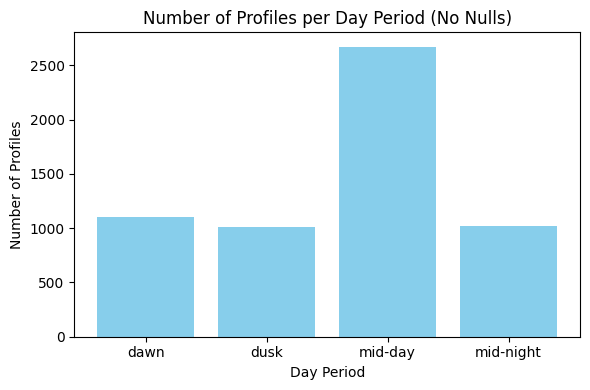

In [11]:
# Remove rows with null day_period
df_no_null = df_with_sun.filter(pl.col("day_period").is_not_null())

# Count unique profile_id per day_period
profile_count_no_null = (
    df_no_null
    .group_by("day_period")
    .agg([
        pl.col("profile_id").n_unique().alias("n_profiles")
    ])
    .sort("day_period")
)

# Bar plot
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(profile_count_no_null["day_period"], profile_count_no_null["n_profiles"], color="skyblue")
plt.xlabel("Day Period")
plt.ylabel("Number of Profiles")
plt.title("Number of Profiles per Day Period (No Nulls)")
plt.tight_layout()
plt.show()

## Smoothing Chla and BBP profiles

In [12]:
df_with_sun = df_with_sun.sort(["profile_id", "DEPTH"])

In [13]:
import glidertools as gt
bbp_baseline, bbp_spikes = gt.cleaning.despike(df_with_sun['BBP700'], 7, spike_method='minmax')

C:\Users\flapet\OneDrive - NOC\Documents\IDAPro\lib\GliderTools\glidertools\helpers.py:76: GliderToolsWarning: Primary input variable is not xr.DataArray data type - no metadata to pass on.
  warnings.warn(msg, category=GliderToolsWarning)


In [14]:

# Despike BBP700
bbp_baseline, _ = gt.cleaning.despike(df_with_sun['BBP700'], 7, spike_method='minmax')
# Despike CHLA
chla_baseline, _ = gt.cleaning.despike(df_with_sun['CHLA'], 7, spike_method='minmax')

chla_nodark = gt.optics.fluorescence_dark_count(chla_baseline, abs(df_with_sun["DEPTH"]))

# Add new columns to df_with_sun
df_with_sun = df_with_sun.with_columns([
    pl.Series("bbp_clean", bbp_baseline),
    pl.Series("chla_clean", chla_nodark)
])



In [15]:
import numpy as np

# Get one random profile_id for each day_period
selected_profiles = []
for period in ["mid-day", "mid-night", "dawn", "dusk"]:
    ids = (
        df_with_sun
        .filter(pl.col("day_period") == period)
        .select("profile_id")
        .unique()
        .to_series()
        .to_list()
    )
    if ids:
        selected_profiles.append(np.random.choice(ids))

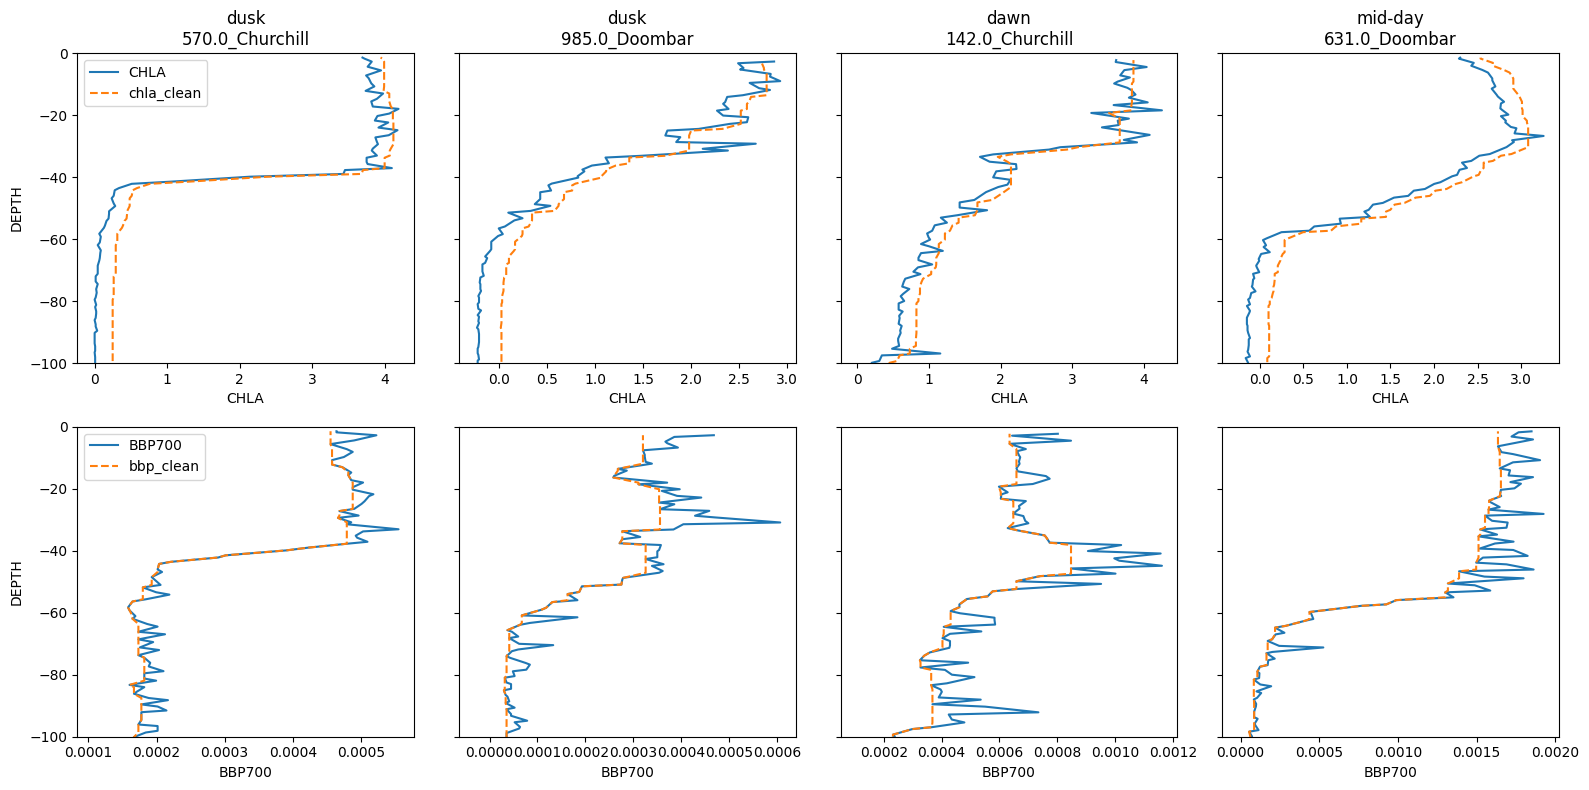

In [16]:
# Plot CHLA/chla_clean and BBP700/bbp_clean vs DEPTH for each selected profile, in two rows

fig, axs = plt.subplots(2, 4, figsize=(16, 8), sharey=True)

for i, profile_id in enumerate(selected_profiles):
    prof = df_with_sun.filter(pl.col("profile_id") == profile_id)
    # Top row: CHLA
    axs[0, i].plot(prof["CHLA"], prof["DEPTH"], label="CHLA", color="tab:blue")
    axs[0, i].plot(prof["chla_clean"], prof["DEPTH"], label="chla_clean", color="tab:orange", linestyle="--")
    axs[0, i].set_title(f"{prof['day_period'][0]}\n{profile_id}")
    axs[0, i].invert_yaxis()
    axs[0, i].set_ylim(-100, 0)
    if i == 0:
        axs[0, i].set_ylabel("DEPTH")
    axs[0, i].set_xlabel("CHLA")
    if i == 0:
        axs[0, i].legend()

    # Bottom row: BBP700
    axs[1, i].plot(prof["BBP700"], prof["DEPTH"], label="BBP700", color="tab:blue")
    axs[1, i].plot(prof["bbp_clean"], prof["DEPTH"], label="bbp_clean", color="tab:orange", linestyle="--")
    axs[1, i].invert_yaxis()
    axs[1, i].set_ylim(-100, 0)
    if i == 0:
        axs[1, i].set_ylabel("DEPTH")
    axs[1, i].set_xlabel("BBP700")
    if i == 0:
        axs[1, i].legend()

plt.tight_layout()
plt.show()

In [17]:
# Add rounded depth column
df_with_sun = df_with_sun.with_columns([
    pl.col("DEPTH").round(0).cast(pl.Int32).alias("DEPTH_ROUND")
])

# Remove depths below -200
df_with_sun = df_with_sun.filter(pl.col("DEPTH_ROUND") >= -40)

df_with_sun = df_with_sun.with_columns(
    (pl.col("chla_clean") / pl.col("bbp_clean")).alias("chla_bbp_ratio")
)

# Find profiles where max(DEPTH_ROUND) > 0
profiles_to_remove = (
    df_with_sun
    .groupby("profile_id")
    .agg(pl.col("DEPTH_ROUND").max().alias("max_round_depth"))
    .filter(pl.col("max_round_depth") > 0)
    .select("profile_id")
    .to_series()
    .to_list()
)

# Filter out those profiles
df_depth_filtered = df_with_sun.filter(~pl.col("profile_id").is_in(profiles_to_remove))

C:\Users\flapet\AppData\Local\Temp\ipykernel_20524\1661293590.py:16: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  .groupby("profile_id")


In [18]:
import numpy as np

# Remove inf values in chla_bbp_ratio and normalise per profile
df_depth_filtered = (
    df_depth_filtered
    .filter(~pl.col("chla_bbp_ratio").is_in([np.inf, -np.inf, None]))  # remove inf/nulls
    .with_columns([
        (
            (pl.col("chla_bbp_ratio") - pl.col("chla_bbp_ratio").min().over("profile_id")) /
            (pl.col("chla_bbp_ratio").max().over("profile_id") - pl.col("chla_bbp_ratio").min().over("profile_id"))
        ).alias("chla_bbp_ratio_norm")
    ])
)

In [19]:


# Group, average, and sort by DEPTH_ROUND before pivoting
fluo_table = (
    df_depth_filtered
    .groupby(["profile_id", "DEPTH_ROUND"])
    .agg([
        pl.col("chla_clean").mean().alias("chla_mean")
    ])
    .sort(["profile_id", "DEPTH_ROUND"])
)

# Pivot to wide format
fluo_table_wide = fluo_table.pivot(
    values="chla_mean",
    index="profile_id",
    columns="DEPTH_ROUND"
)

# Interpolate missing values along each row (profile)
fluo_table_pd = fluo_table_wide.to_pandas().set_index("profile_id")
fluo_table_pd = fluo_table_pd.apply(lambda row: row.interpolate(method="linear", limit_direction="both"), axis=1)
fluo_table_pd = fluo_table_pd.dropna(axis=0, how="any")

fluo_table_final = pl.from_pandas(fluo_table_pd.reset_index())
fluo_table_final

C:\Users\flapet\AppData\Local\Temp\ipykernel_20524\4231028639.py:4: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  .groupby(["profile_id", "DEPTH_ROUND"])


profile_id,-40,-39,-38,-36,-35,-34,-32,-31,-30,-28,-27,-26,-25,-24,-23,-21,-20,-18,-17,-16,-15,-13,-12,-10,-8,-7,-5,-4,-3,-2,-33,-29,-19,-11,-37,-22,-9,-6,-1,0,-14
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""10.0_Churchill…",2.1442,2.3714,3.1453,3.1737,3.2589,3.2589,3.2589,3.2589,3.2589,3.2589,3.4222,3.4293,3.4293,3.4293,3.4293,3.4293,3.4293,3.4293,3.4293,3.4293,3.4293,3.4222,3.4009,3.4009,3.4009,3.4009,3.3938,3.3938,3.3938,3.3938,3.3938,3.3938,3.3938,3.3938,3.3938,3.3938,3.3938,3.3938,3.3938,3.3938,3.3938
"""10.0_Doombar""",0.9727,1.1218,1.2638,2.3359,2.5418,2.8329,3.124,3.124,3.124,3.124,3.14175,3.1595,3.1595,3.1595,3.2021,3.2021,3.2021,3.2021,3.2021,3.2163,3.2163,3.2163,3.2163,3.2163,3.2163,3.195,3.195,3.14175,3.0885,3.03525,2.982,3.124,3.2021,3.2163,3.2163,3.2163,3.2163,3.2163,3.2163,3.2163,3.2163
"""10.0_Nelson""",2.0808,2.2633,2.367933,2.472567,2.5772,2.64655,2.7159,2.8108,2.9057,2.9495,2.9933,3.0006,3.0006,3.0006,3.0006,3.0006,3.1466,3.1466,3.1466,3.1466,3.1466,3.1466,3.1466,3.1466,3.1466,3.1466,3.1466,3.1466,2.9568,2.767,2.5772,2.9933,3.06995,3.1466,2.4896,3.0006,3.1466,3.1466,2.9787,2.9787,2.9787
"""100.0_Churchil…",1.2709,1.2709,1.2709,1.2709,1.2567,1.349,1.5194,1.5194,1.5194,1.5194,1.6401,1.6401,1.6401,1.67205,1.704,1.704,1.704,1.704,1.704,1.704,1.699267,1.694533,1.6898,1.6898,1.66495,1.6401,1.6401,1.6401,1.4768,1.4484,1.4839,1.5194,1.704,1.6898,1.2709,1.46615,1.6614,1.6401,1.656667,1.673233,1.6898
"""100.0_Doombar""",1.6472,1.6472,1.6472,1.6472,1.6472,1.6117,1.633,1.633,1.633,1.64365,1.6543,1.6543,1.6543,1.6543,1.6543,1.6543,1.6543,1.6543,1.6543,1.6543,1.6543,1.6543,1.6543,1.6543,1.6401,1.6401,1.6401,1.638325,1.63655,1.634775,1.633,1.633,1.6543,1.6543,1.6472,1.6543,1.6543,1.6401,1.644833,1.649567,1.6543
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""997.0_Nelson""",1.4238,1.77055,1.9786,2.7597,2.7816,2.7816,2.9203,2.9203,2.9203,2.9203,2.903875,2.88745,2.940375,2.9933,2.9933,2.9933,2.9933,2.9933,2.9933,2.9933,2.9422,2.84365,2.8181,2.6064,2.083233,2.0443,2.0443,1.891,1.6282,1.6282,2.9203,2.9203,2.9933,2.8181,2.7305,2.4166,2.1027,2.0443,2.319267,2.594233,2.8692
"""998.0_Doombar""",0.7597,0.8307,0.8307,0.89815,0.9656,1.137183,1.308767,1.48035,1.524725,1.5691,1.5691,1.5691,1.617025,1.66495,2.000425,2.3359,2.3359,3.2802,3.3228,3.50385,3.6849,3.7062,3.7062,3.7062,3.7062,3.7062,3.7062,3.097375,2.48855,1.879725,1.2709,1.5691,3.2802,3.7062,0.8307,2.3359,3.02105,3.7062,3.7062,3.7062,3.7062
"""998.0_Nelson""",2.04065,2.330825,2.621,2.80715,2.816275,2.8254,2.85825,2.914825,2.9714,2.9714,2.9714,2.9714,2.9714,2.9714,2.9714,2.96045,2.9495,2.9495,2.9495,2.9495,2.9495,2.9495,2.8619,2.7743,2.6648,2.3947,2.473957,2.553214,2.632471,2.711729,2.790986,2.870243,2.9495,2.8181,2.88015,2.9422,2.9422,2.9422,2.9422,2.9422,2.9422


In [20]:
ca_data = fluo_table_pd.copy()
ca_data[ca_data <= 0] = 1e-6

import prince
# CA requires all values to be strictly positive and no NaNs
ca_data = fluo_table_pd.copy()
# Remove 'profile_id' column if present (should only be index)
ca_data = ca_data.reset_index(drop=True)

ca_data[ca_data <= 0] = 1e-6  # set all non-positive values to a small positive constant
ca_data = ca_data.dropna(axis=0, how="any").dropna(axis=1, how="any")

In [21]:
# Set all values <= 0 to a small positive constant
ca_data = fluo_table_pd.copy()
ca_data[ca_data <= 0] = 1e-6

ca_data = ca_data.replace([np.inf, -np.inf], 999)
ca_data[ca_data >=  1000] = 999


In [22]:
for col in ca_data.columns:
    col_vals = ca_data[col]
    finite_vals = col_vals[np.isfinite(col_vals)]
    
    if finite_vals.empty:
        continue  # skip if all values are inf or NaN

    max_val = finite_vals.max()
    min_val = finite_vals.min()

    ca_data.loc[col_vals == np.inf, col] = max_val
    ca_data.loc[col_vals == -np.inf, col] = min_val

C:\Users\flapet\AppData\Local\Temp\ipykernel_20524\3234579340.py:24: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  .groupby("profile_id")


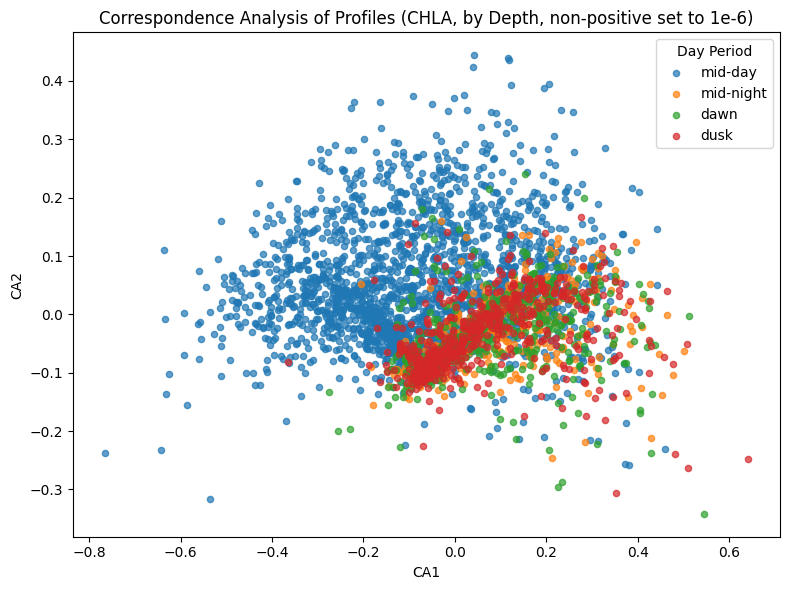

In [23]:

import prince
# CA requires all values to be strictly positive and no NaNs
ca_data = fluo_table_pd.copy()
# Add "depth" in front of all column names
ca_data.columns = ["depth" + str(col) for col in ca_data.columns]

# Remove 'profile_id' column if present (should only be index)
if "profile_id" in ca_data.columns:
    ca_data = ca_data.set_index("profile_id")

ca_data[ca_data <= 0] = 1e-6  # set all non-positive values to a small positive constant
ca_data = ca_data.dropna(axis=0, how="any").dropna(axis=1, how="any")

ca = prince.CA(n_components=4, n_iter=10, copy=True, check_input=True, engine='sklearn', random_state=42)
ca = ca.fit(ca_data)

# Get CA coordinates for each profile
ca_coords = ca.row_coordinates(ca_data)
ca_coords.index = ca_data.index

# Get day_period for each profile_id
profile_period = (
    df_with_sun
    .groupby("profile_id")
    .agg(pl.col("day_period").mode().alias("day_period_mode"))
    .explode("day_period_mode")  # Unwrap list
    .unique(subset=["profile_id"])  # Ensure only one row per profile_id
    .rename({"day_period_mode": "day_period"})
    .to_pandas()
    .set_index("profile_id")["day_period"]
)




# Align day_period with CA coordinates
ca_coords["day_period"] = ca_coords.index.map(profile_period)

# Plot CA1 vs CA2, colored by day_period
plt.figure(figsize=(8,6))
for period in ca_coords["day_period"].dropna().unique():
    mask = ca_coords["day_period"] == period
    plt.scatter(
        ca_coords.loc[mask, 0],
        ca_coords.loc[mask, 1],
        label=period,
        alpha=0.7,
        s=20
    )
plt.xlabel("CA1")
plt.ylabel("CA2")
plt.title("Correspondence Analysis of Profiles (CHLA, by Depth, non-positive set to 1e-6)")
plt.legend(title="Day Period")
plt.tight_layout()
plt.show()


In [61]:
# Add CA1 and CA2 to df_with_sun
# First, get CA coordinates for each profile_id as a DataFrame
ca_coords_df = ca_coords[[0, 1, 2, 3]].copy()
ca_coords_df.columns = ["CA1", "CA2", "CA3", "CA4"]
ca_coords_df["profile_id"] = ca_coords_df.index

# Convert to polars DataFrame for joining
ca_coords_pl = pl.from_pandas(ca_coords_df.reset_index(drop=True))

# Join CA1 and CA2 to df_with_sun
df_final = df_depth_filtered.join(ca_coords_pl, on="profile_id", how="left")

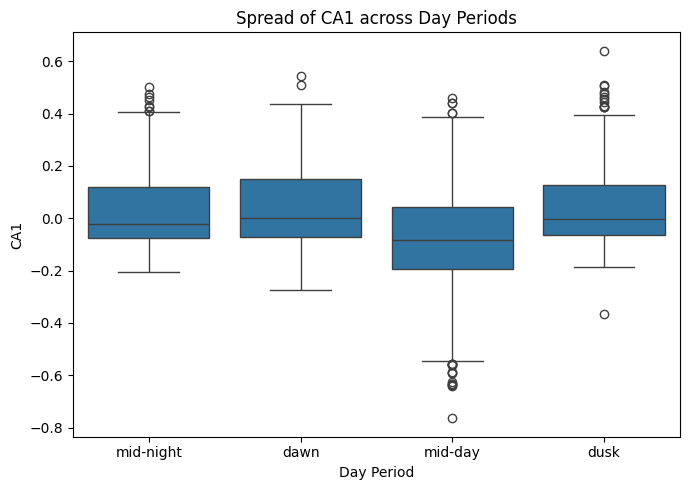

In [50]:
import seaborn as sns

# Prepare DataFrame for plotting: CA1 and day_period for each profile_id
ca1_dayperiod_df = (
    df_final
    .select(["profile_id", "CA1", "day_period"])
    .unique(subset=["profile_id"])
    .to_pandas()
)

plt.figure(figsize=(7, 5))
sns.boxplot(data=ca1_dayperiod_df, x="day_period", y="CA1", order=["mid-night", "dawn", "mid-day", "dusk"])
plt.xlabel("Day Period")
plt.ylabel("CA1")
plt.title("Spread of CA1 across Day Periods")
plt.tight_layout()
plt.show()

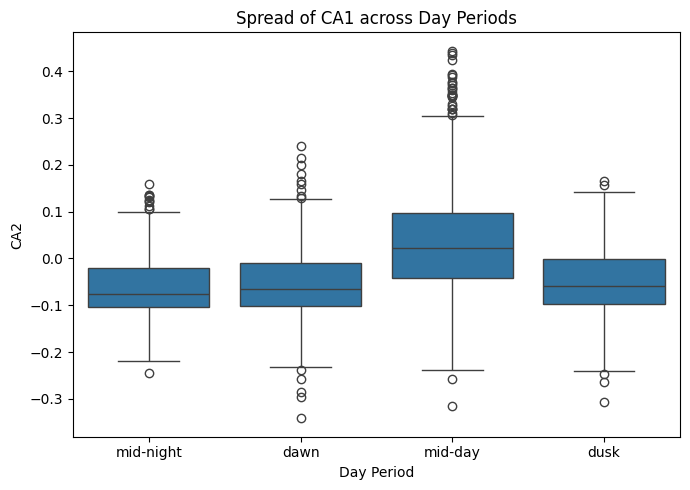

In [26]:

# Prepare DataFrame for plotting: CA1 and day_period for each profile_id
ca1_dayperiod_df = (
    df_final
    .select(["profile_id", "CA2", "day_period"])
    .unique(subset=["profile_id"])
    .to_pandas()
)

plt.figure(figsize=(7, 5))
sns.boxplot(data=ca1_dayperiod_df, x="day_period", y="CA2", order=["mid-night", "dawn", "mid-day", "dusk"])
plt.xlabel("Day Period")
plt.ylabel("CA2")
plt.title("Spread of CA1 across Day Periods")
plt.tight_layout()
plt.show()

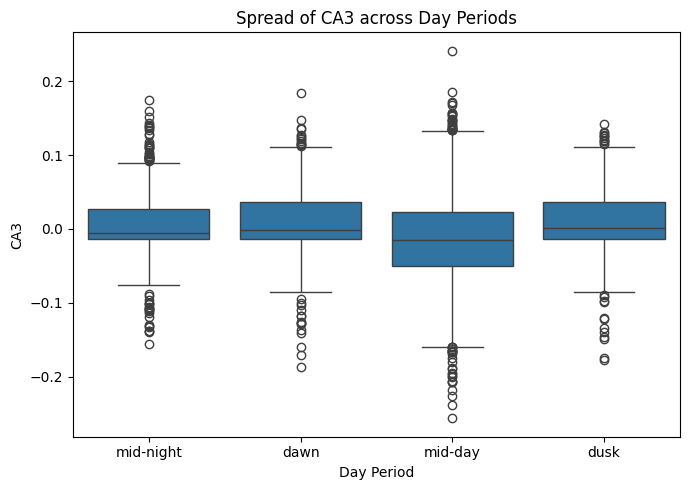

In [27]:
# Prepare DataFrame for plotting: CA1 and day_period for each profile_id
ca1_dayperiod_df = (
    df_final
    .select(["profile_id", "CA3", "day_period"])
    .unique(subset=["profile_id"])
    .to_pandas()
)

plt.figure(figsize=(7, 5))
sns.boxplot(data=ca1_dayperiod_df, x="day_period", y="CA3", order=["mid-night", "dawn", "mid-day", "dusk"])
plt.xlabel("Day Period")
plt.ylabel("CA3")
plt.title("Spread of CA3 across Day Periods")
plt.tight_layout()
plt.show()

In [51]:
# Now, for each target CA spot, find the closest profile, plot its fluorescence profile, and plot the mean profile of the 20 closest profiles
# Convert ca_coords to numpy for distance calculation
ca_coords_np = ca_coords[[0, 1]].to_numpy()
profile_ids = ca_coords.index.to_numpy()

# Define target CA spots
spots = [(-0.4, 0.3), (0.2, -0.2), (1.0, 0.4)]
spot_labels = ["(-0.4, 0.3)", "(0.2, -0.2)", "(1.0, 0.4)"]

In [62]:
# Normalise CHLA per profile in df_final
df_final = df_final.with_columns(
    (
        (pl.col("CHLA") - pl.col("CHLA").min().over("profile_id")) /
        (pl.col("CHLA").max().over("profile_id") - pl.col("CHLA").min().over("profile_id"))
    ).alias("CHLA_norm")
)

In [63]:
# Round CA1 to the nearest tenth
df_final = df_final.with_columns(
    pl.col("CA1").round(1).alias("CA1_round")
)

# Group by rounded CA1 and DEPTH_ROUND, then average chla_clean
chla_avg_by_ca1_depth = (
    df_final
    .groupby(["CA1_round", "DEPTH_ROUND"])
    .agg([
        pl.col("chla_bbp_ratio").mean().alias("chla_clean_mean")
    ])
    .sort(["CA1_round", "DEPTH_ROUND"])
)

C:\Users\flapet\AppData\Local\Temp\ipykernel_20524\4082379719.py:9: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  .groupby(["CA1_round", "DEPTH_ROUND"])


In [64]:
# Extract CA1, CA2, CA3 for each unique profile
ca_features = (
    df_final
    .select(["profile_id", "CA1", "CA2", "CA3"])
    .unique(subset=["profile_id"])
    .to_pandas()
    .set_index("profile_id")
    .dropna()
)

In [55]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering



def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

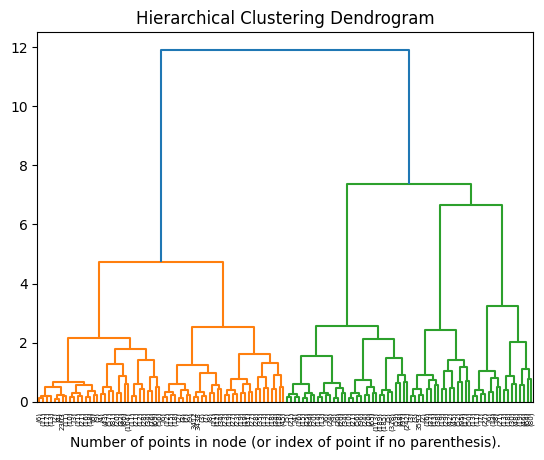

In [65]:
X = ca_features

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=4, n_clusters=None)

model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=6)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [66]:
# Assign cluster labels using the fitted AgglomerativeClustering model
cluster_labels = model.labels_

# Map profile_id to cluster label
cluster_df = ca_features.copy()
cluster_df["cluster"] = cluster_labels
cluster_df = cluster_df.reset_index()[["profile_id", "cluster"]]

# Convert to polars DataFrame for joining
cluster_pl = pl.from_pandas(cluster_df)

# Add cluster column to df_final
df_clustered = df_final.join(cluster_pl, on="profile_id", how="left")

In [67]:
# Normalise chla_clean per profile_id between 0 and 1 in df_final
df_clustered = df_clustered.with_columns(
    (
        (pl.col("chla_clean") - pl.col("chla_clean").min().over("profile_id")) /
        (pl.col("chla_clean").max().over("profile_id") - pl.col("chla_clean").min().over("profile_id"))
    ).alias("chla_clean_norm")
)

C:\Users\flapet\AppData\Local\Temp\ipykernel_20524\2376265942.py:4: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  .groupby(["cluster", "DEPTH_ROUND"])


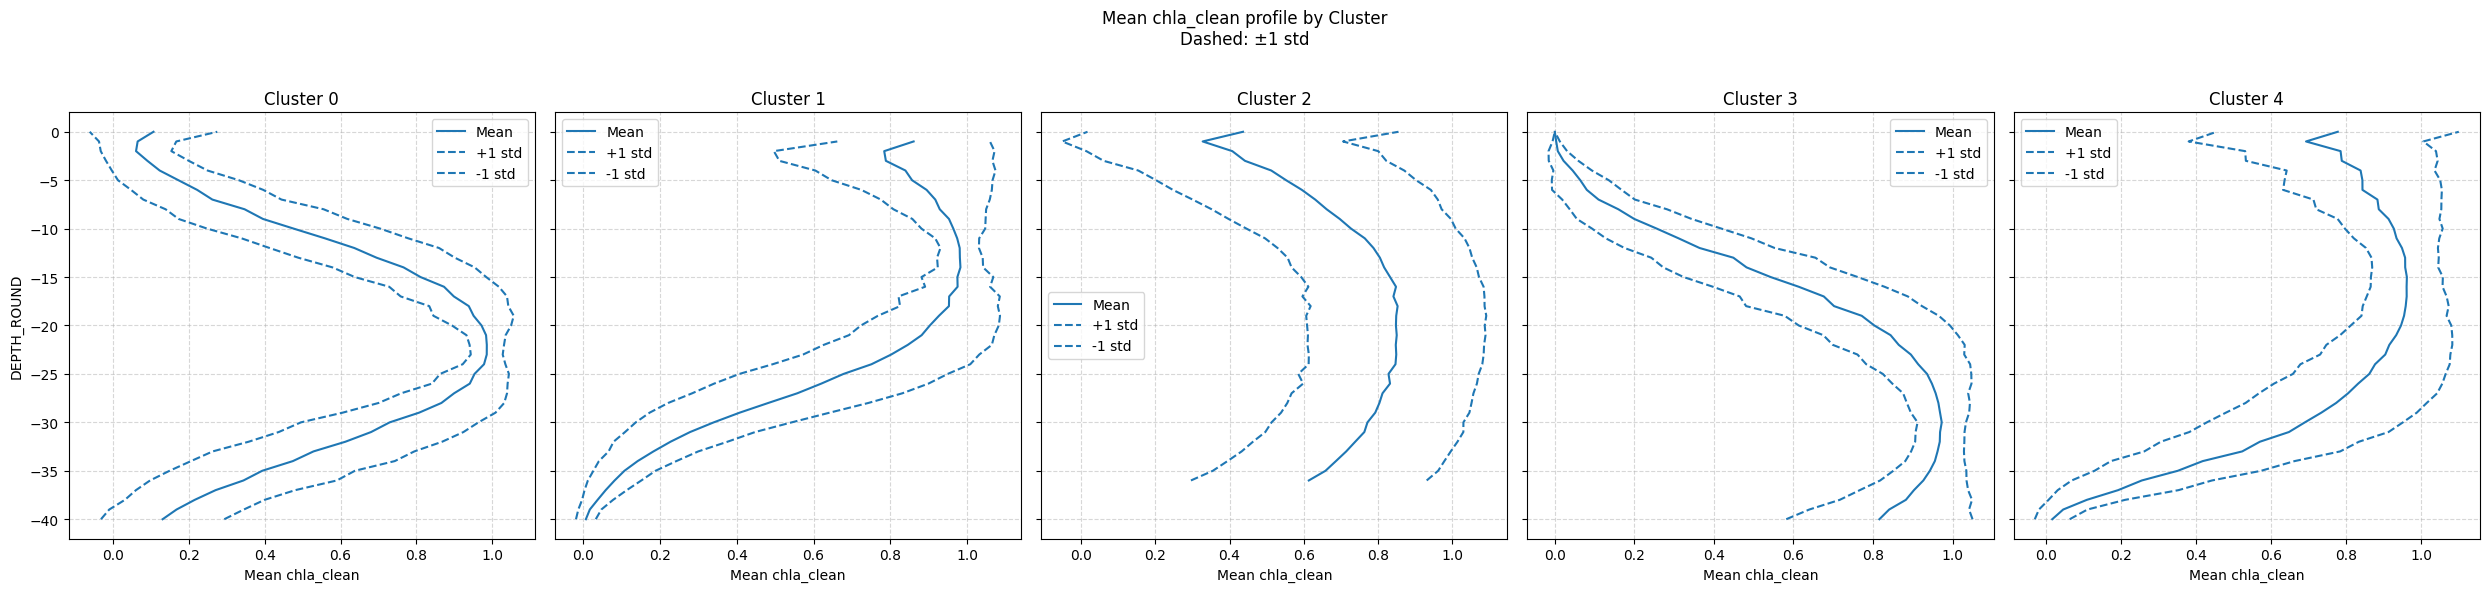

In [76]:
# Compute mean chla_clean profile per cluster and depth
cluster_chla_profile = (
    df_clustered
    .groupby(["cluster", "DEPTH_ROUND"])
    .agg([
        pl.col("chla_clean_norm").mean().alias("chla_clean_mean"),
        pl.col("chla_clean_norm").std().alias("chla_clean_std"),
    ])
    .sort(["cluster", "DEPTH_ROUND"])
)

# Get unique clusters and sort
clusters = sorted(cluster_chla_profile["cluster"].unique().to_list())

fig, axs = plt.subplots(1, len(clusters), figsize=(5 * len(clusters), 6), sharey=True)

if len(clusters) == 1:
    axs = [axs]  # Ensure axs is iterable

for idx, cl in enumerate(clusters):
    prof = cluster_chla_profile.filter(pl.col("cluster") == cl)
    mean = prof["chla_clean_mean"]
    std = prof["chla_clean_std"]
    depth = prof["DEPTH_ROUND"]
    axs[idx].plot(mean, depth, label="Mean", color="tab:blue")
    axs[idx].plot(mean + std, depth, linestyle="--", color="tab:blue", label="+1 std")
    axs[idx].plot(mean - std, depth, linestyle="--", color="tab:blue", label="-1 std")
    axs[idx].set_xlabel("Mean chla_clean")
    axs[idx].set_title(f"Cluster {cl}")
    axs[idx].grid(True, linestyle="--", alpha=0.5)
    if idx == 0:
        axs[idx].set_ylabel("DEPTH_ROUND")
    axs[idx].legend()

plt.suptitle("Mean chla_clean profile by Cluster\nDashed: ±1 std")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

C:\Users\flapet\AppData\Local\Temp\ipykernel_20524\2992649408.py:4: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  .groupby(["cluster", "DEPTH_ROUND"])


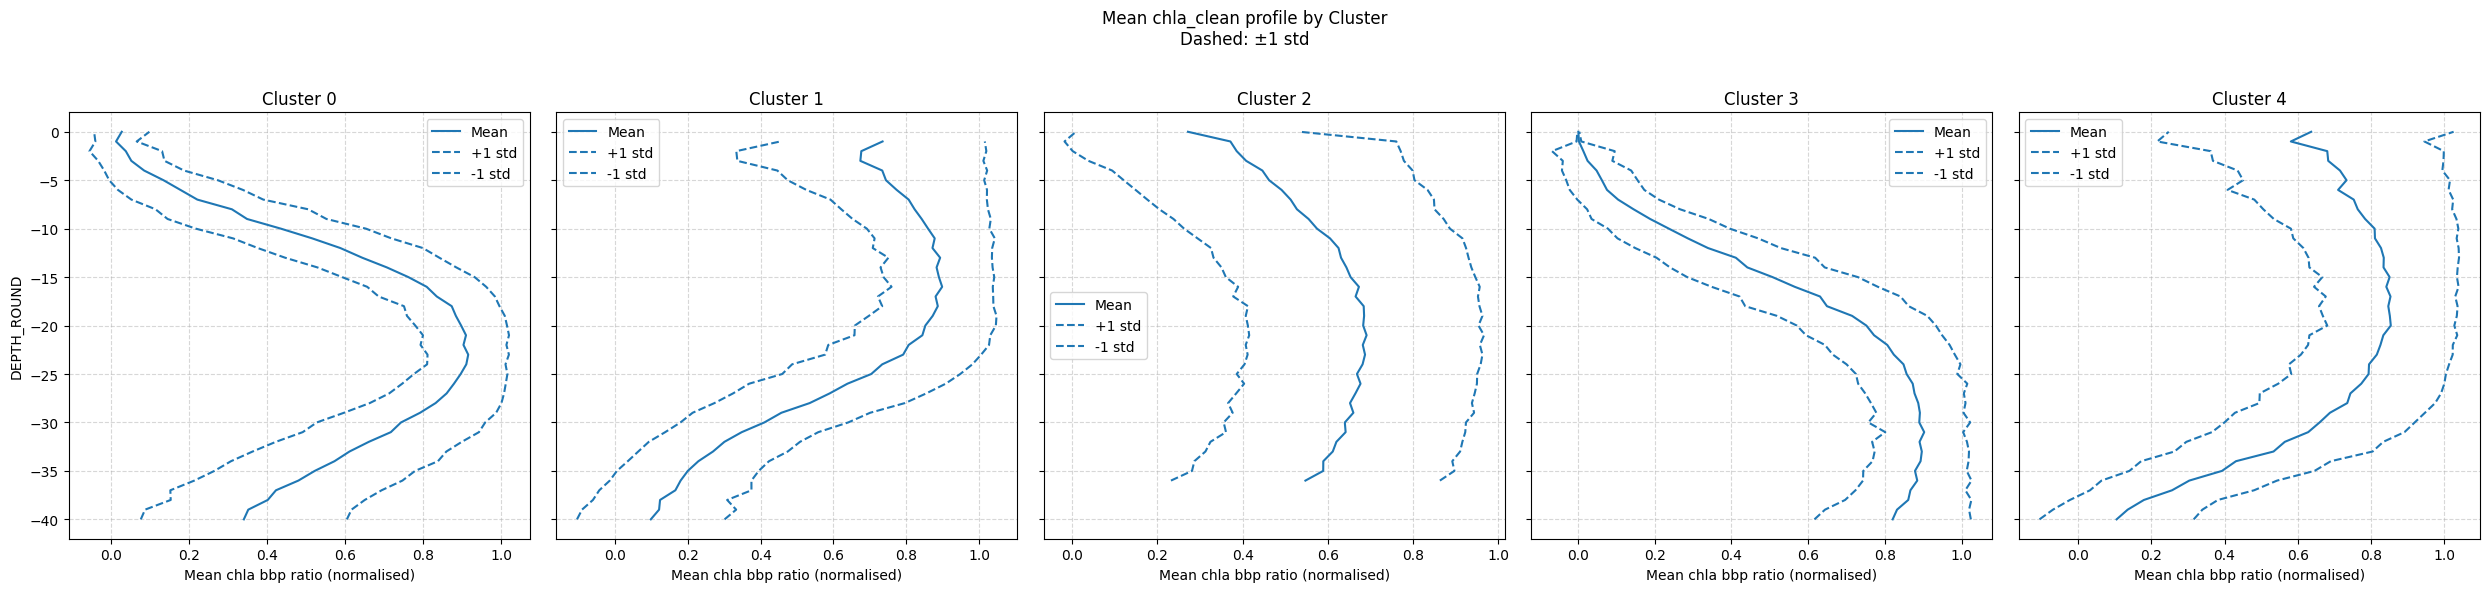

In [78]:
# Compute mean chla_clean profile per cluster and depth
cluster_chla_bbp_profile = (
    df_clustered
    .groupby(["cluster", "DEPTH_ROUND"])
    .agg([
        pl.col("chla_bbp_ratio_norm").mean().alias("chla_bbp_clean_mean"),
        pl.col("chla_bbp_ratio_norm").std().alias("chla_bbp_clean_std"),
    ])
    .sort(["cluster", "DEPTH_ROUND"])
)

# Get unique clusters and sort
clusters = sorted(cluster_chla_profile["cluster"].unique().to_list())

fig, axs = plt.subplots(1, len(clusters), figsize=(5 * len(clusters), 6), sharey=True)

if len(clusters) == 1:
    axs = [axs]  # Ensure axs is iterable

for idx, cl in enumerate(clusters):
    prof = cluster_chla_bbp_profile.filter(pl.col("cluster") == cl)
    mean = prof["chla_bbp_clean_mean"]
    std = prof["chla_bbp_clean_std"]
    depth = prof["DEPTH_ROUND"]
    axs[idx].plot(mean, depth, label="Mean", color="tab:blue")
    axs[idx].plot(mean + std, depth, linestyle="--", color="tab:blue", label="+1 std")
    axs[idx].plot(mean - std, depth, linestyle="--", color="tab:blue", label="-1 std")
    axs[idx].set_xlabel("Mean chla bbp ratio (normalised)")
    axs[idx].set_title(f"Cluster {cl}")
    axs[idx].grid(True, linestyle="--", alpha=0.5)
    if idx == 0:
        axs[idx].set_ylabel("DEPTH_ROUND")
    axs[idx].legend()

plt.suptitle("Mean chla_clean profile by Cluster\nDashed: ±1 std")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [70]:
# Count number of profiles per cluster and day_period
cluster_period_counts = (
    df_clustered
    .select(["profile_id", "cluster", "day_period"])
    .unique(subset=["profile_id"])
    .group_by(["cluster", "day_period"])
    .agg(pl.len().alias("n_profiles"))
    .sort(["cluster", "day_period"])
    .to_pandas()
)

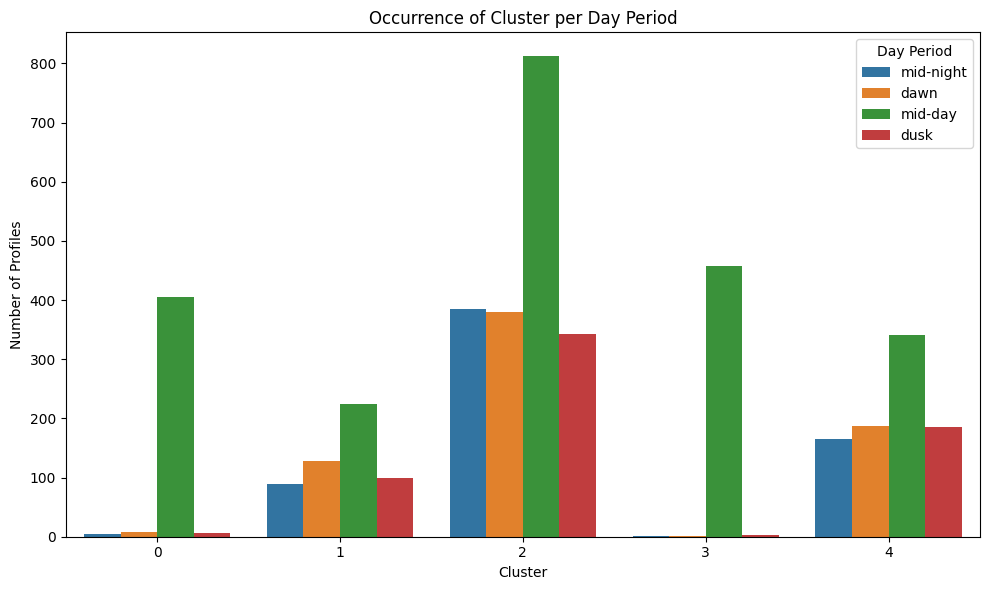

In [71]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=cluster_period_counts,
    x="cluster",
    y="n_profiles",
    hue="day_period",
    order=sorted(cluster_period_counts["cluster"].unique()),
    hue_order=["mid-night", "dawn", "mid-day", "dusk"]
)
plt.xlabel("Cluster")
plt.ylabel("Number of Profiles")
plt.title("Occurrence of Cluster per Day Period")
plt.legend(title="Day Period")
plt.tight_layout()
plt.show()

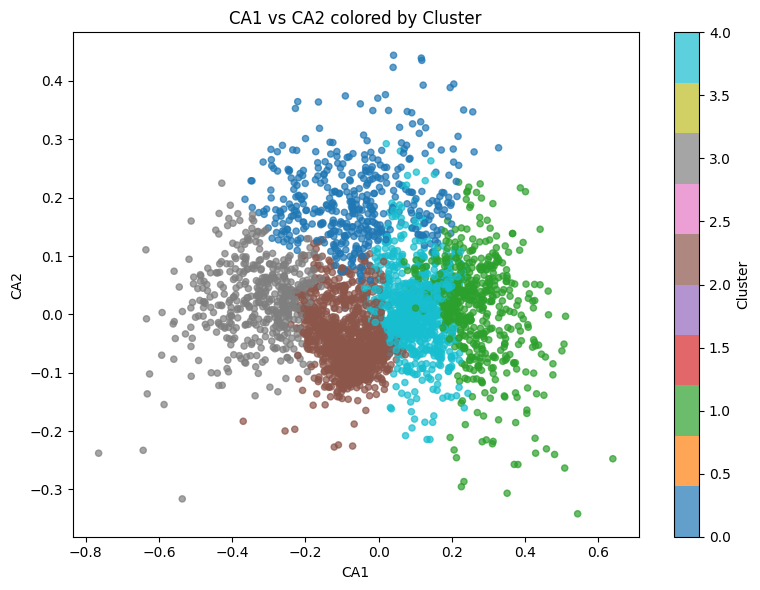

In [75]:
# Prepare DataFrame for plotting: CA1, CA2, and cluster for each profile_id
ca_cluster_df = (
    df_clustered
    .select(["profile_id", "CA1", "CA2", "cluster"])
    .unique(subset=["profile_id"])
    .to_pandas()
    .dropna(subset=["CA1", "CA2", "cluster"])
)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    ca_cluster_df["CA1"], ca_cluster_df["CA2"],
    c=ca_cluster_df["cluster"], cmap="tab10", s=20, alpha=0.7
)
plt.xlabel("CA1")
plt.ylabel("CA2")
plt.title("CA1 vs CA2 colored by Cluster")
plt.colorbar(scatter, label="Cluster")
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Define common depth grid (e.g., every 5 m from 0 to 100 m)
depth_grid = np.arange(0, 101, 5)

fig, axs = plt.subplots(1, 3, figsize=(15, 6), sharey=True)

for idx, (spot, label) in enumerate(zip(spots, spot_labels)):
    # Compute distances to CA spot
    dists = np.linalg.norm(ca_coords_np - np.array(spot), axis=1)
    nearest_idx = np.argmin(dists)
    nearest_profile_id = profile_ids[nearest_idx]

    # Get 20 closest profiles
    closest_indices = np.argsort(dists)[:20]
    closest_profile_ids = profile_ids[closest_indices]

    # Get fluorescence profiles and convert to pandas
    profiles = fluo_table_wide.filter(pl.col("profile_id").is_in(closest_profile_ids))
    profiles_pd = profiles.to_pandas().set_index("profile_id")

    # Interpolate all profiles onto the common depth grid
    def interp_profile(row):
        depths = row.index.astype(float)
        values = row.values
        return np.interp(depth_grid, depths, values)

    profiles_interp = profiles_pd.apply(interp_profile, axis=1, result_type="expand")
    profiles_interp.columns = depth_grid

    # Compute mean and std, apply Gaussian smoothing
    mean_profile = profiles_interp.mean(axis=0)
    std_profile = profiles_interp.std(axis=0)
    mean_profile = gaussian_filter1d(mean_profile, sigma=1)
    std_profile = gaussian_filter1d(std_profile, sigma=1)

    # Plot mean ± std
    axs[idx].plot(mean_profile, depth_grid, label="Mean (20 closest)", color="tab:blue")
    axs[idx].fill_betweenx(depth_grid, mean_profile - std_profile, mean_profile + std_profile,
                           color="tab:blue", alpha=0.2)

    # Plot the single closest profile
    single_profile = fluo_table_wide.filter(pl.col("profile_id") == nearest_profile_id).to_pandas().set_index("profile_id").iloc[0]
    single_profile.index = single_profile.index.astype(float)
    single_profile = single_profile.sort_index().interpolate(method="linear", limit_direction="both")

    # Interpolate onto the same depth grid
    single_interp = np.interp(depth_grid, single_profile.index, single_profile.values)
    axs[idx].plot(single_interp, depth_grid, label=f"Closest profile\n{nearest_profile_id}",
                  color="tab:orange", linestyle="--")

    # Style the plot
    axs[idx].invert_yaxis()
    axs[idx].set_xlabel("Fluorescence")
    axs[idx].set_title(f"CA spot {label}")
    axs[idx].grid(True, linestyle="--", alpha=0.5)
    axs[idx].set_xlim(0, 1)

    if idx == 0:
        axs[idx].set_ylabel("Depth (m)")
    axs[idx].legend()

plt.tight_layout()
plt.show()
